In [1]:
## IMPORT ##

import sys
import glob
import os
import json
from os import listdir
from os.path import isfile, join

from collections import defaultdict,Counter
import math

import pandas as pd
#import plotly as py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# vcf parser and associated utilities
# VariantFile is the the pysam vcf file handler returning a pysam vcf record
from pysam import VariantFile
from pybedtools import BedTool, create_interval_from_list

#Fot the http request to jvenn
from IPython.display import display, HTML
#py.offline.init_notebook_mode(connected=True)



In [42]:
## FUNCTIONS ##

def getDetectedRecordsId(record,sv_type,tools):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
            
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                detected_all[sv][t].append(r.id)
    return detected_all


def formatDetectedVariant(record,sv_type,tools,verbose=True):
    detected_all = defaultdict(list)
    #Initialisation
    for sv in sv_type:
        detected_all[sv]=defaultdict(list)
        for t in tools:
            detected_all[sv][t]=[]
    for sv in sv_type:
        for r in record[sv]:
            tool_name = r.id.split('_')[0]
            if tool_name not in tools:
                print('Unsupported tool results',tool_name)
                continue
            else:
                detected_all[sv][tool_name].append(r)
                
            if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                detected_all[sv]['PASS'].append(r)
    if verbose:
        print("Tools results detected : ",tools)    
        print("Number of variant DETECTED for each SV_TYPE : ")
        for t in tools:
            print("   ",t,":")
            for sv in sv_type:
                print("       ",sv,":",len(detected_all[sv][t]))
    return detected_all

def initFormattedRecord(sv_type,tools):
    record = defaultdict(list)
    for sv in sv_type:
        record[sv]=defaultdict(list)
        for t in tools:
            record[sv][t]=[]
    return record

def getFormattedRecordBySize(record,sv_type,tools,min_size,max_size):
    size_record = initFormattedRecord(sv_type,tools)
    for sv in sv_type:
        for t in tools:
            for r in record[sv][t]:
                if min_size <= abs(r.stop-r.start)+1 < max_size:
                    size_record[sv][t].append(r)
    return size_record
    
    

def getNumbersFromFormattedRecord(record,sv_type,tools,min_size=0, max_size=0):
    
    number_record = initFormattedRecord(sv_type,tools)
    
    for sv in sv_type:
        for t in tools:
            number_record[sv][t]=defaultdict(list)
            number_record[sv][t]['PASS']=0
            number_record[sv][t]['DUPLICATE']=0
            number_record[sv][t]['FILTEREDOUT']=0
            
    if (max_size > 0) and (min_size < max_size):
        record = getFormattedRecordBySize(record,sv_type,tools,min_size,max_size)
        
    for sv in sv_type:
        for t in tools:
            if t == 'PASS':
                number_record[sv][t]['PASS'] = len(record[sv][t])
                number_record[sv][t]['DUPLICATE'] = 0
                number_record[sv][t]['FILTEREDOUT'] = 0
            else:
                for r in record[sv][t]:
                    if (len(r.filter)==0) or ((len(r.filter) == 1) and ('PASS' in r.filter)):
                        number_record[sv][t]['PASS']+=1
                    elif len(r.filter)==1 and 'DUPLICATE' in r.filter:
                        number_record[sv][t]['DUPLICATE'] +=1
                    else:
                        number_record[sv][t]['FILTEREDOUT'] +=1
    
    return number_record
    
def getDataFrame(record,sv_type,tools):
    data=[]
    for sv in sv_type:
        data_tool=[]
        for t in tools:
            data_tool.append(len(record[sv][t]))
        data.append(data_tool)
    return data

def vcf_to_pybed(vcf_records):
    """
    Convert vcf records to bed records
    :param vcf_records: the vcf records
    :type vcfrecords: a list of vcf records
    :return: the corresponding betools records
    :rtype: a bedtools object
    """
    intervals = []
    for record in vcf_records:
        chrom = record.chrom
        start = record.start # pysam start is 0-based inclusive just like bed
        end = record.stop  # pysam stop is 0-based exclusive just like bed
        name = record.id
        interval_list = list(map(str, [chrom, start, end, name]))
        #print(interval_list)
        intervals.append(create_interval_from_list(interval_list))
    #print(intervals)
    #return BedTool(intervals).sort()
    return BedTool(intervals)

In [43]:
## VARIABLES ##
allowed_sv_type=['INV','DEL','DUP']
#species=['bee','chicken','goat','poplar','human','zea']
allowed_tools=['PASS','pindel','delly','lumpy','genomestrip']
#detection_dir="../batch001/filtered/"
#detection_dir="data/bee_20/filtered/"
detection_dir="."
tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
#tools_color=['#3498db','#e74c3c','#1abc9c','#f39c12','#9b59b6']
#size_interval=[(0,200),(200,500),(500,1000),(1000,10000),(10000,50000),(50000,2000000)]
#size_interval_name=["0-200","200-500","500-1k","1k-10k","10k-50k","50k+"]

In [122]:
def loadSVfromDetectionDirectories(allowed_sv_type, allowed_tools, directory, extension='vcf.gz', size_min=0, size_max=0, verbose=False):
    records = defaultdict()
    tools = []
    sv_type = []
    samples = []
    chroms = defaultdict()

    #print(sv_type, directories, extension, size_min, size_max)
    for sv in allowed_sv_type:
        sv_dir = directory + "/" + sv + "/"            
        try:
            variant_files = [f for f in listdir(sv_dir) if isfile(join(sv_dir, f))]
            sv_type.append(sv)
            if sv not in records:
                records[sv]=[]
        except FileNotFoundError:
            print("Directory not Found : ",join(sv_dir))
            continue
            
        for file in variant_files:
            if file.endswith(extension):
                try:
                    sv_in = VariantFile(join(sv_dir,file))
                    #print("ctg",sv_in.header.contigs.keys())
                    for line in str(sv_in.header).split("\n"):
                        if line.startswith("##contig"):
                            temp = line.replace("=",",").replace(">","").split(",")
                            if int(temp[4]) > 500000:
                                chroms[temp[2]]=temp[4]
                except ValueError:
                    print("Incorrect format for file : ",join(sv_dir,file))

                for r in sv_in:
                    if (size_min == 0 and size_max == 0) or (r.rlen>=size_min and r.rlen<=size_max):
                        records[sv].append(r)
                        for t in r.info['TOOLSUPPORT']:
                            if t in allowed_tools and t not in tools:
                                tools.append(t)
                        for s in r.samples:
                            if s not in samples:
                                samples.append(s)
    if verbose:                    
        print("SV_TYPE : ",sv_type)
        print("Number of variant for each SV_TYPE : ")
        for sv in sv_type:
            print("   ",sv,len(records[sv]))
    
    sv_type.sort()
    tools.sort()
    return records,sv_type,tools,samples,chroms


sv_records,sv_type,tools,samples,chroms =loadSVfromDetectionDirectories(allowed_sv_type,allowed_tools,detection_dir)

print("SV found\t",sv_type)
print("Tools found\t",tools)
print("Number of samples\t",len(samples))
print("Nunmber of contig >500kb\t",len(chroms))
cumulative_length=0
for ctg in chroms:
    cumulative_length+=int(chroms[ctg])
print("Length of contig >500kb\t",cumulative_length)



SV found	 ['DEL', 'DUP', 'INV']
Tools found	 ['delly', 'lumpy', 'pindel']
Number of samples	 20
Nunmber of contig >500kb	 16
Length of contig >500kb	 220705582


In [5]:
#print(headers[0])
#for ctg in headers[0].contigs:
#    print(ctg)

In [51]:
def table2htmlstr(data,table_title,column_header,row_header):
    html_table_str=""
    table_style = "style=\"font-size: 16px;border:none\""
    column_header_style = "style=\"background-color:midnightblue; color:white; font-size: 20px;\""
    row_header_style = "style=\"text-align:center;font-size: 20px;\""
    
    cell_width = str(int(100/(len(column_header)+1)))+"%"

    html_table_str = "<font size=5>"+table_title+"</font>"
    html_table_str += "<table "+table_style+">"
    html_table_str += "<tr "+column_header_style+"><td width="+cell_width+"></td>"
    for t in tools:
        html_table_str += "<td width="+cell_width+">"+t+"</td>"
    html_table_str += "</tr>"

    for sv in sv_type:
        html_table_str +="<tr><td "+row_header_style+">"+sv+"</td>"
        for t in tools:
            html_table_str += "<td>"+str(data[sv][t])+"</td>"
        html_table_str +="</tr>"
    html_table_str +='</table>'
    
    return html_table_str

##init
numbers = defaultdict()
for sv in sv_type:
    numbers[sv] = defaultdict(Counter)
    for t in tools:
        numbers[sv][t]=0

for sv in sv_type:
    for v in sv_records[sv]:
        for t in v.info['TOOLSUPPORT']:
            if t in allowed_tools:
                numbers[sv][t]+=1
    numbers[sv]['combined'] = len(sv_records[sv])

html_table_str = table2htmlstr(numbers,"Number of SV found by tool",tools,sv_type+['combined'])
display(HTML(html_table_str))


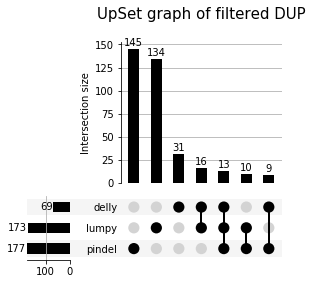

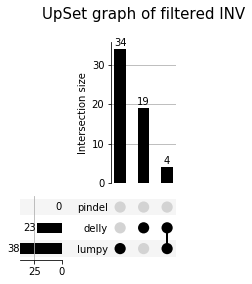

In [70]:
from upsetplot import UpSet
#vcffile = "./DEL/concat_DEL_final.vcf.gz"

#variants = VariantFile(vcffile)
for sv in sv_type:
    fig = plt.figure(figsize=(20, 20))
    status = []
    for v in sv_records[sv]:
        counter = list(map(lambda x: x in v.info['TOOLSUPPORT'], tools))
        counter.append(v.id)
        status.append(counter)
    df = pd.DataFrame.from_records(status,columns=tools+["id"])
    df = df.set_index(tools)

    upset = UpSet(df, subset_size='count', sort_by="cardinality", show_counts='%d')
    upset.plot(fig = fig)
    plt.title("UpSet graph of filtered " + sv + "\n",fontsize=15)
    plt.show()



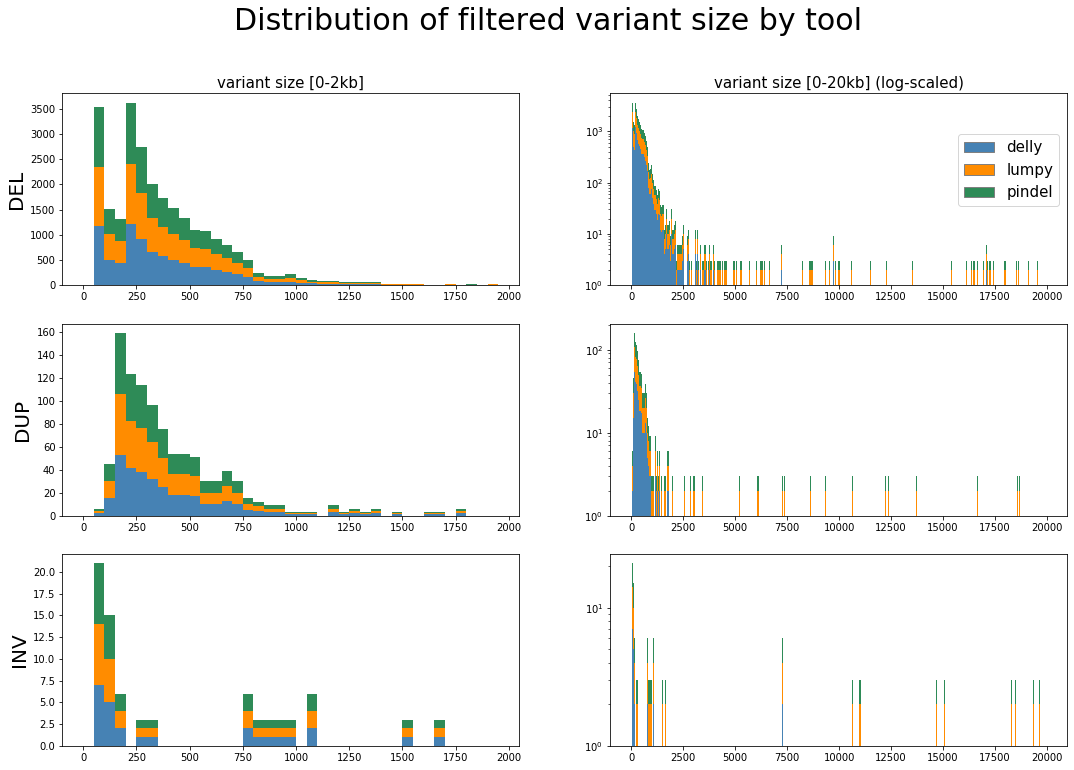

In [76]:
svlen_tools = tools
#print(tools[0:1])
svlen_tools_color = ['steelblue','darkorange','seagreen','red','yellow'][0:len(tools)]

#print(duplicate_id['INV']['pindel'])

#for t in svlen_tools:

dict_lengths = defaultdict()
for sv in sv_type:
    dict_lengths[sv]=defaultdict(list)
    for t in tools:
        dict_lengths[sv][t] = [r.rlen for r in sv_records[sv]]

        

f,axarr = plt.subplots(3,2,sharex=False,sharey=False,figsize=(18,12))
index=-1
for sv in sv_type:
    index+=1
    lengths = []
    for t in svlen_tools:
        lengths.append(dict_lengths[sv][t])
    axarr[index][0].hist(x=lengths, bins=[i for i in range(0, 2000, 50)],stacked=True, histtype='bar', label=svlen_tools, color=svlen_tools_color)
    axarr[index][1].hist(x=lengths, bins=[i for i in range(0, 20000, 50)],stacked=True, histtype='bar', label=svlen_tools, color=svlen_tools_color, log=True)
    axarr[index][0].set_ylabel(sv,fontsize=20)

axarr[0][0].set_title("variant size [0-2kb]",fontsize=15)
axarr[0][1].set_title("variant size [0-20kb] (log-scaled)",fontsize=15)

a_val = 1
legend=[]
for i in range(0,len(svlen_tools)):
    legend.append(mpatches.Patch( edgecolor='grey', facecolor=svlen_tools_color[i],alpha=a_val,label=svlen_tools[i]))
plt.legend(handles = legend,loc="right",fontsize=15, bbox_to_anchor=(1,3))
#l2 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#l3 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#l4 = mpatches.Patch( edgecolor='grey', facecolor='white',alpha=a_val,label='Filtered out')
#plt.legend(handles = [l1,l2],loc="right",fontsize=20, bbox_to_anchor=(1.5,0.5))

f.suptitle("Distribution of filtered variant size by tool",fontsize=30)
plt.show()



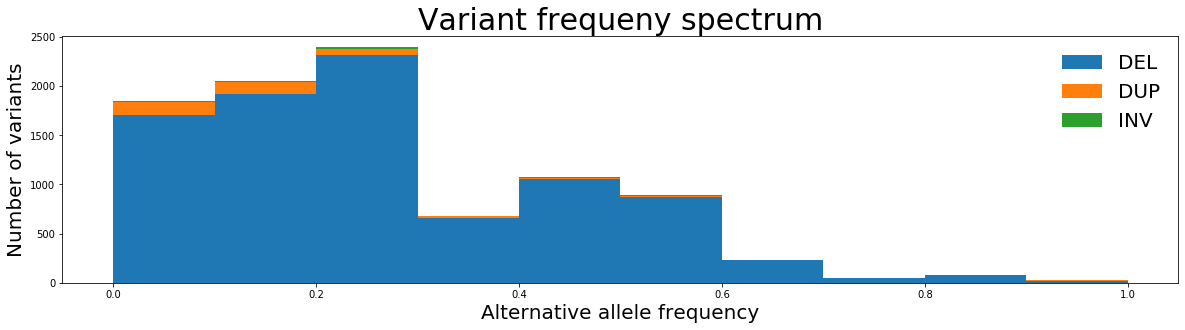

In [77]:
### Nouveau graph donné par Thomas : frequency spectrum
def var_frequency(rec):
    alt_alleles = 0
    informative_samples = 0 
    for s in rec.samples:
        geno = rec.samples[s]['GT']
        if not valid_geno:
            continue
        informative_samples += 1
        if geno == (0,1):
            alt_alleles += 1
        elif geno == (1,1):
            alt_alleles += 1 ### =>2
    if informative_samples == 0: ### 2* ( on passe en nb de copie)
        return None
    else:
        return float(alt_alleles)/informative_samples 



def valid_geno(geno):
    if geno == (0,0) or geno == (0,1) or geno == (1,1):
        return True
    else:
        return False

frequencies = []
dict_of_frequencies=defaultdict(list)
##standard_svtype = ['DEL', 'INV', 'DUP']

for sv in sv_type:
    dict_of_frequencies[sv] = []
    for r in sv_records[sv]:
        freq = var_frequency(r)
        if freq is not None:
            dict_of_frequencies[sv].append(freq)

fig = plt.figure(figsize=(20, 10)) 
#fig.suptitle("Variant frequeny spectrum", fontsize=14)
##standard_order = ['DEL', 'INV', 'DUP']
names, frequencies = zip(
        *sorted([(svtype, frequencies) for svtype, frequencies in dict_of_frequencies.items()],
                key=lambda x: sv_type.index(x[0])))
plt.subplot(2, 1, 1)
plt.hist(x=frequencies,
         bins=10,
         range=(0,1),
         stacked=True,
         histtype='bar',
         label=names)
plt.xlabel('Alternative allele frequency',fontsize=20)
plt.ylabel('Number of variants',fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.title("Variant frequeny spectrum", fontsize=30)
plt.show()